# Draft functions to calculate extreme indices
- save final versions of draft functions into file "Extreme_indices_functions"

In [1]:
import xarray as xr, matplotlib.pyplot as plt
from importlib import reload # need to use this if I edit a function file
import os
import numpy as np
import pandas as pd
import cartopy.crs as ccrs # to add in continents and change map projections 
from matplotlib.colors import LinearSegmentedColormap # to change colour bar????
import dask.diagnostics # dask allows you to check how long something is taking to load
import climtas # needed to count event statistics with a specified duration
import seaborn as sns
import scipy.stats # to calculate correlation

In [151]:
# import custom functions
import sys 
sys.path.append('/home/563/kb6999/Functions') # use this if the function file is in a different directory to the notebook

import frequently_used_functions as func
import plotting_functions as fplot
import model_functions as funcM
import reanalysis_functions as funcR
import Extreme_indices_functions as funcX
# import obs_functions as funcO

In [3]:
# define path where obs data is store
path = '/g/data/w48/kb6999/Observations/obs_netcdfs_T/'

In [4]:
# open daily T data from 5 stations 
daily_T = xr.open_dataset(f'{path}Daily_T_Aus_5S.nc')
daily_T

<xarray.Dataset>
Dimensions:  (station: 5, time: 15705)
Coordinates:
  * time     (time) datetime64[ns] 1878-01-01 1878-01-02 ... 1920-12-31
  * station  (station) object 'Adelaide' 'Cape_Otway' ... 'Melbourne' 'Sydney'
Data variables:
    Tmin     (station, time) float64 ...
    Tmax     (station, time) float64 ...

In [5]:
dataset = daily_T.Tmin
dataset

<xarray.DataArray 'Tmin' (station: 5, time: 15705)>
array([[10.7, 13.1, 13.9, ..., 14.6, 15. , 18.2],
       [11.7, 11.1, 12.2, ..., 13.6, 15.4, 14.2],
       [ 9.7, 12.6, 15.1, ..., 18.4, 16.6,  nan],
       [11.5, 13.3,  8.9, ..., 13.3, 14.2, 15.5],
       [19.8, 19.5, 17. , ..., 20. , 19.4, 21.1]])
Coordinates:
  * time     (time) datetime64[ns] 1878-01-01 1878-01-02 ... 1920-12-31
  * station  (station) object 'Adelaide' 'Cape_Otway' ... 'Melbourne' 'Sydney'

In [7]:
frost_test = dataset.where(dataset<0).resample(time='M').count(dim='time')
frost_test

<xarray.DataArray 'Tmin' (station: 5, time: 516)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * time     (time) datetime64[ns] 1878-01-31 1878-02-28 ... 1920-12-31
  * station  (station) object 'Adelaide' 'Cape_Otway' ... 'Melbourne' 'Sydney'

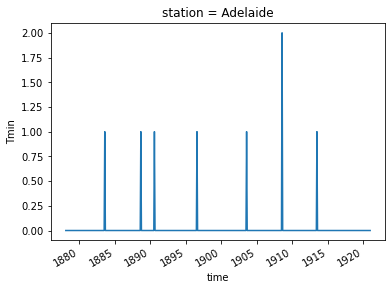

In [8]:
frost_test.sel(station='Adelaide').plot()

In [98]:
# count of number of days Tmin (ds) is less than 0C
def frostdays(ds_Tmin, time_group):
    """ Extreme index: Frost Days - count of number of days Tmin (ds) is less than 0C.
        
        Args:
        ds_Tmin (xarray): data set of minimum temperature (Tmin)
        time_group (string): group data by time_group (e.g. 'M', 'Y') 
    """
    count_FD = ds_Tmin.where(ds_Tmin<0).resample(time = time_group).count(dim = 'time')
    
    return count_FD

In [99]:
# count of number of days when Tmax is greater than 25C
def summerdays(ds_Tmax, time_group):
    """ Extreme index: Summer Days - count of number of days Tmax (ds) is greater than 25C.
        
        Args:
        ds_Tmax (xarray): data set of maximum temperature (Tmax)
        time_group (string): group data by time_group (e.g. 'M', 'Y')
    """
    count_SU = ds_Tmax.where(ds_Tmax>25).resample(time = time_group).count(dim = 'time')
    
    return count_SU

In [111]:
# count of number of days Tmax (ds) is less than 0C
def icingdays(ds_Tmax, time_group):
    """ Extreme index: Icing Days - count of number of days Tmax (ds) is less than 0C.
        
        Args:
        ds_Tmax (xarray): data set of maximum temperature (Tmax)
        time_group (string): group data by time_group (e.g. 'M', 'Y')
    """
    count_ID = ds_Tmax.where(ds_Tmax<0).resample(time = time_group).count(dim = 'time')
    
    return count_ID

In [112]:
# count of number of days Tmin (ds) is greater than 20C
def tropicalnights(ds_Tmin, time_group):
    """ Extreme index: Tropical Nights - count of number of days Tmin (ds) is greater than 20C.
        
        Args:
        ds_Tmin (xarray): data set of minimum temperature (Tmin)
        time_group (string): group data by time_group (e.g. 'M', 'Y') 
    """
    count_TR = ds_Tmin.where(ds_Tmin>20).resample(time = time_group).count(dim = 'time')
    
    return count_TR

In [102]:
# maximum daily maximum temperature each month 
def T_maxmax(ds_Tmax, time_group):
    """ Extreme index: TXx - maximum of daily maximum temperature each month
        
        Args:
        ds_Tmax (xarray): data set of maximum temperature (Tmax)
        time_group (string): group data by time_group (e.g. 'M') 
    """
    #group data by month - find max each month
    TXx = ds_Tmax.resample(time=time_group).max(dim='time')
    
    return TXx

In [103]:
# maximum daily minimum temperature each month 
def T_maxmin(ds_Tmin, time_group):    
    """ Extreme index: TNx - maximum daily minimum temperature each month 
        
        Args:
        ds_Tmin (xarray): data set of minimum temperature (Tmin)
        time_group (string): group data by time_group (e.g. 'M') 
    """
    #group data by month - find max each month
    TNx =  ds_Tmin.resample(time=time_group).max(dim='time')
    
    return TNx

In [104]:
# minimum daily minimum temperature each month 
def T_minmin(ds_Tmin, time_group):
    """ Extreme index: TNn - minimum daily minimum temperature each month 
        
        Args:
        ds_Tmin (xarray): data set of minimum temperature (Tmin)
        time_group (string): group data by time_group (e.g. 'M') 
    """
    #group data by month - find min each month
    TNn = ds_Tmin.resample(time=time_group).min(dim='time')
    
    return TNn

In [105]:
# minimum daily maximum temperature each month 
def T_minmax(ds_Tmax, time_group):
    """ Extreme index: TXn - minimum of daily maximum temperature each month
        
        Args:
        ds_Tmax (xarray): data set of maximum temperature (Tmax)
        time_group (string): group data by time_group (e.g. 'M') 
    """    
    #group data by month - find min each month
    TXn = ds_Tmax.resample(time=time_group).min(dim='time')
    
    return TXn

## percentiles

In [146]:
# Percentage of days when TN or TX < 10th percentile 
def T_10p(dataset, time_group, start_date, end_date):
    """ Extreme index: TN10p/TX10p - percentage of days when TN or TX < 10th percentile
        
        Args:
        dataset (xarray): data set of either Tmin or Tmax
        time_group (string): group data by time_group (e.g. 'M')
        start_date (string): start date of period over which to calculate percentile
        end_date (string): end date of period over which to calculate percentile
    """    
    # find the 10th percentile
    p10 = dataset.sel(time=slice(start_date, end_date)).quantile(0.1, dim=['time'])
    
    # group data by month - find min each month
    T_10p_count = dataset.where(dataset < p10).resample(time = time_group).count(dim = 'time')
    
    # find where any NaN values occur
    NaN_ds = dataset.isnull() # listed as True if it's a NaN value
    # count the number of NaN values per month 
    NaN_count = NaN_ds.where(NaN_ds==True).resample(time = time_group).count(dim = 'time')

    # find the no. days in each month (remembering to minus any days that have NaN values)
    mon_range = T_10p_count.time.dt.days_in_month - NaN_count

    # convert the (monthly) count of TN10p to a percentage
    T_10p = T_10p_count*100/(mon_range)
    
    # remove the quantile dimension so I can combine datasets (ie T_90p) later
    del T_10p['quantile']
    
    return T_10p

In [145]:
# Percentage of days when TN or TX > 90th percentile 
def T_90p(dataset, time_group, start_date, end_date):
    """ Extreme index: TN90p/TX90p - percentage of days when TN or TX > 90th percentile
        
        Args:
        dataset (xarray): data set of either Tmin or Tmax
        time_group (string): group data by time_group (e.g. 'M')
        start_date (string): start date of period over which to calculate percentile
        end_date (string): end date of period over which to calculate percentile
    """    
    # find the 10th percentile
    p90 = dataset.sel(time=slice(start_date, end_date)).quantile(0.9, dim=['time'])
    
    # group data by month - find min each month
    T_90p_count = dataset.where(dataset > p90).resample(time = time_group).count(dim = 'time')
    
    # find where any NaN values occur
    NaN_ds = dataset.isnull() # listed as True if it's a NaN value
    # count the number of NaN values per month 
    NaN_count = NaN_ds.where(NaN_ds==True).resample(time = time_group).count(dim = 'time')

    # find the no. days in each month (remembering to minus any days that have NaN values)
    mon_range = T_90p_count.time.dt.days_in_month - NaN_count

    # convert the (monthly) count of TN10p to a percentage
    T_90p = T_90p_count*100/(mon_range)
    
    # remove the quantile dimension so I can combine datasets (ie T_10p) later
    del T_90p['quantile']
    
    return T_90p

In [108]:
# daily temperature range 
def daily_range(ds_Tmin, ds_Tmax, time_group):
    """ Extreme index: DTR - average daily temperature range for each month (1 value per month of each year)
        
        Args:
        ds_Tmin (xarray): data set of minimum temperature (Tmax)
        ds_Tmax (xarray): data set of maximum temperature (Tmax)
        time_group (string): group data by time_group (e.g. 'M') 
    """      
    DTR = (ds_Tmax - ds_Tmin).resample(time=time_group).mean(dim='time')
    
    return DTR    

In [109]:
# extreme temperature range 
def extreme_range(ds_TNn, ds_TXx):
    """ Extreme index: ETR - extreme temperature range for each month (1 value per month of each year)
        
        Args:
        ds_TNn (xarray): data set of minimum temperature (Tmax)
        ds_TXx (xarray): data set of maximum temperature (Tmax)
        time_group (string): group data by time_group (e.g. 'M') 
    """  
    ETR = ds_TXx - ds_TNn
    
    return ETR

In [149]:
# function to calculate all extreme indices and put them in an xarray
def extreme_indices(dataset, time_group, start_date, end_date):
    
    import xarray as xr 
    
    # select out Tmin and Tmax from input dataset
    ds_Tmin = dataset.Tmin
    ds_Tmax = dataset.Tmax
    
    # calculate all the extreme indices needed
    FD = frostdays(ds_Tmin, time_group)
    SU = summerdays(ds_Tmax, time_group)
    ID = icingdays(ds_Tmax, time_group)
    TR = tropicalnights(ds_Tmin, time_group)
    TXx = T_maxmax(ds_Tmax, time_group)
    TNx = T_maxmin(ds_Tmin, time_group)
    TNn = T_minmin(ds_Tmin, time_group)
    TXn = T_minmax(ds_Tmax, time_group)
    TN10p = T_10p(ds_Tmin, time_group, start_date, end_date)
    TX10p = T_10p(ds_Tmax, time_group, start_date, end_date)
    TN90p = T_90p(ds_Tmin, time_group, start_date, end_date)
    TX90p = T_90p(ds_Tmax, time_group, start_date, end_date)
    DTR = daily_range(ds_Tmin, ds_Tmax, time_group)
    ETR = extreme_range(TNn, TXx)
    
    # put all indicies into one xarray
    indicies = xr.Dataset({'FD': FD, 'SU': SU, 'ID': ID, 'TR': TR, 'TXx': TXx, 'TNx': TNx, 'TNn': TNn, 'TXn': TXn, 'TN10p': TN10p, 'TX10p': TX10p, 'TN90p': TN90p, 'TX90p': TX90p, 'DTR': DTR, 'ETR': ETR})
    
    return indicies
                    

In [150]:
extreme_indices(daily_T, 'M', '1880', '1900')

<xarray.Dataset>
Dimensions:  (station: 5, time: 516)
Coordinates:
  * time     (time) datetime64[ns] 1878-01-31 1878-02-28 ... 1920-12-31
  * station  (station) object 'Adelaide' 'Cape_Otway' ... 'Melbourne' 'Sydney'
Data variables: (12/14)
    FD       (station, time) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    SU       (station, time) int64 31 21 14 8 0 0 0 1 2 ... 4 0 0 0 0 1 6 14 16
    ID       (station, time) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    TR       (station, time) int64 7 6 7 0 0 0 0 0 0 1 4 ... 0 0 0 0 0 0 0 0 1 4
    TXx      (station, time) float64 45.2 36.7 39.6 31.8 ... 26.0 27.9 36.7 33.3
    TNx      (station, time) float64 28.6 25.9 26.8 19.2 ... 15.6 16.7 20.9 21.1
    ...       ...
    TN10p    (station, time) float64 0.0 0.0 0.0 0.0 0.0 ... 6.667 0.0 0.0 0.0
    TX10p    (station, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    TN90p    (station, time) float64 38.71 32.14 35.48 10.0 ... 0.0 6.667 30.0
    TX90p    (station, time) float64 58.06 25.0 16.13 0.0 ... 6.452 36.67 36.67
    DTR      (station, time) float64 16.49 11.43 9.635 ... 8.587 9.387 7.557
    ETR      (station, time) float64 34.5 27.1 29.3 23.0 ... 19.3 18.6 24.0 19.6

In [138]:
time_group = 'M'

In [139]:
TN10p = T_10p(dataset, time_group, start_date, end_date)
TN90p = T_90p(dataset, time_group, start_date, end_date)

In [143]:
del TN90p['quantile']

In [144]:
TN90p

<xarray.DataArray (station: 5, time: 516)>
array([[38.70967742, 32.14285714, 35.48387097, ...,  3.22580645,
         6.66666667, 22.58064516],
       [16.12903226, 25.        , 19.35483871, ...,  0.        ,
         3.44827586, 13.79310345],
       [48.38709677, 66.66666667, 63.33333333, ...,  0.        ,
        20.        , 26.66666667],
       [35.48387097, 57.14285714, 25.80645161, ...,  3.22580645,
        16.66666667, 29.03225806],
       [51.61290323, 53.57142857, 38.70967742, ...,  0.        ,
         6.66666667, 30.        ]])
Coordinates:
  * time     (time) datetime64[ns] 1878-01-31 1878-02-28 ... 1920-12-31
  * station  (station) object 'Adelaide' 'Cape_Otway' ... 'Melbourne' 'Sydney'

In [140]:
xr.Dataset({'TN10p': TN10p, 'TN90p': TN90p})

MergeError: conflicting values for variable 'quantile' on objects to be combined. You can skip this check by specifying compat='override'.

In [113]:
FD = frostdays(dataset,'M')
ID = icingdays(dataset,'M')
ID

<xarray.DataArray 'Tmin' (station: 5, time: 516)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * time     (time) datetime64[ns] 1878-01-31 1878-02-28 ... 1920-12-31
  * station  (station) object 'Adelaide' 'Cape_Otway' ... 'Melbourne' 'Sydney'

In [120]:
models = xr.Dataset({'FD': FD, 'ID': ID})

In [121]:
models

<xarray.Dataset>
Dimensions:  (station: 5, time: 516)
Coordinates:
  * time     (time) datetime64[ns] 1878-01-31 1878-02-28 ... 1920-12-31
  * station  (station) object 'Adelaide' 'Cape_Otway' ... 'Melbourne' 'Sydney'
Data variables:
    FD       (station, time) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    ID       (station, time) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0

In [114]:
ds = []
ds.append(FD)
ds.append(ID)


In [115]:
names = ['FD', 'ID']

In [119]:
indices = xr.concat(ds, coords='minimal')
#indices.coords['indices'] = names

TypeError: concat() missing 1 required positional argument: 'dim'

In [118]:
indices

<xarray.DataArray 'Tmin' (indices: 2, station: 5, time: 516)>
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]])
Coordinates:
  * time     (time) datetime64[ns] 1878-01-31 1878-02-28 ... 1920-12-31
  * station  (station) object 'Adelaide' 'Cape_Otway' ... 'Melbourne' 'Sydney'
  * indices  (indices) <U2 'FD' 'ID'